In [0]:
## setup

import gym

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import random
import numpy as np
from matplotlib import pyplot as plt

# clear rendered env display
from IPython.display import clear_output
# freeze rendered env display
from time import sleep

In [0]:
## hyperparameter

# You should change
LEARNING_RATE = 1e-5
HIDDEN_NODES = 5
BATCH_SIZE = 100
ALPHA = 0.1
GAMMA = 0.6
EPSILON = 0.1
EPISODES = 100

# Don't change
INPUT_SIZE = 1
OUTPUT_SIZE = 6
SEED = 123

In [228]:
## environment

ENV_NAME = 'Taxi-v3'
env = gym.make(ENV_NAME)
env.seed(SEED)

[123]

In [0]:
## experience replay

class Replay:
  def __init__(self):
    self.buffer = []
    self.length = 0
    self.max_length = 10000

  def write(self, data):
    if self.length >= self.max_length:
      self.buffer.pop(0)
      self.length -= 1
    self.buffer.append(data)
    self.length += 1

  def read(self, batch_size):
    # at beginning buffer is almost empty, so batch is smaller than batch_size
    return random.sample(self.buffer, min(batch_size, self.length))

In [0]:
# Q network

class Network:
  def __init__(self, session, n_in, n_out):
    self.session = session
    self.n_in = n_in
    self.n_out = n_out
    self.n_hidden = HIDDEN_NODES
    # define input
    self.x = tf.placeholder(tf.float32, [None, n_in], name = 'x')
    # define output
    self.y = tf.placeholder(tf.float32, [None, n_out], name = 'y')
    # ?
    self.x_in = tf.reshape(self.x, [-1, self.n_in])
    # 1 hidden layer neural network
    self.W_fc1 = tf.get_variable('W_fc1', shape = [self.n_in, self.n_hidden])
    self.b_fc1 = tf.get_variable('b_fc1', shape = [self.n_hidden])
    # activation relu
    self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name = 'hidden_layer'))
    # output layer
    self.W_fc2 = tf.get_variable('W_fc2', shape = [self.n_hidden, self.n_out])
    self.b_fc2 = tf.get_variable('b_fc2', shape = [self.n_out])
    # predicted q function
    self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name = 'output_layer')

    # calculate loss
    self.loss = tf.reduce_sum(tf.square(self.y - self.q), 1)
    self.train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(self.loss)

  # only compute q function
  def compute(self, x):
    return self.session.run(self.q, feed_dict = {self.x: np.reshape(x, [-1, self.n_in])})

  # actual training of neural network
  def train(self, x_batch, y_batch):
    _ = self.session.run(self.train_step, feed_dict = {self.x: x_batch,
                                                       self.y: y_batch})

In [0]:
## agent

class Agent:
  def __init__(self, tf_session):
    self.n_in = 1
    self.n_out = 6 
    self.total_reward = 0
    self.gamma = GAMMA
    self.epsilon = EPSILON
    self.batch_size = BATCH_SIZE
    self.replay_buffer = Replay()
    self.q = Network(tf_session, self.n_in, self.n_out)

  def gather_experience(self, last_observation, action, reward, observation):
    self.replay_buffer.write((last_observation, action, reward, observation))

  # return action index
  def choose_action(self, observation):
    # epsilon greedy policy is performed here

    # exploitation
    # np.random.rand is uniform [0,1]
    if np.random.rand() > self.epsilon:
      return np.argmax(self.q.compute(observation)[0,:])

    # exploration
    else:
      # random action from 0 to 5 out of 6 actions
      return int(np.random.randint(low = 0, high = 5, size = 1, dtype = 'int'))

  # set total reward
  def set_total_reward(self, new_total):
    self.total_reward = new_total

  # gather reward
  def gather_reward(self, reward):
    self.total_reward += reward

  # get total rewards
  def get_total_reward(self):
    return self.total_reward
  
  # q update
  def q_update(self):
    # get a batch from replay buffer
    # batch is list of turples
    batch = self.replay_buffer.read(self.batch_size)
    # s[0] is last_observation
    # first element of turple in the list is state index
    q_last = self.q.compute([s[0] for s in batch])

    # initialize
    q_this = np.zeros_like(q_last)
    # batch[i][3] is observation
    ind_not_none = [i for i in range(np.shape(batch)[0]) if batch[i][3] is not None]
    # b[3] is observation
    q_this_not_none = self.q.compute([b[3] for b in batch if b[3] is not None])
    
    for i in range(len(ind_not_none)):
      # store n_out number of q predictions by neural network regression
      q_this[ind_not_none[i], :] = q_this_not_none[i, :]

    x_batch = np.zeros([np.shape(batch)[0], self.n_in])
    y_batch = np.zeros([np.shape(batch)[0], self.n_out])

    for i in range(np.shape(batch)[0]):
      # batch[i][0] is last_observation
      x_batch[i, :] = batch[i][0]

      for j in range(self.n_out):
        # batch[i][1] is action
        if j == batch[i][1]:
          # batch[i][2] is reward
          # This is y_i
          y_batch[i, j] = batch[i][2] + self.gamma * np.max(q_this[i])
        else:
          y_batch[i, j] = q_last[i][j]

    self.q.train(x_batch, y_batch)

In [232]:
## training

with tf.Graph().as_default():
  ep_rewards = []
  with tf.Session() as sess:
    agent = Agent(sess)
    sess.run(tf.global_variables_initializer())

    for ep in range(EPISODES):

      # monitor training process
      if ep % 10 == 0:
        print("episode", ep)

      # initialize
      # env.reset() in taxi returns index of states out of 500
      last_observation = env.reset()
      agent.set_total_reward(0)

      # Why 201?
      for t in range(201):

        # draw action
        action = agent.choose_action(last_observation)
        # draw next state and reward
        observation, reward, done, info = env.step(action)

        # when taxi drop a passenger at destination, done = True
        if done == True:
          observation = None

        # accumulate reward
        agent.gather_reward(reward)
        agent.gather_experience(last_observation, action, reward, observation)

        # update q function
        agent.q_update()
        # iterate
        last_observation = observation
        
        # goal
        if done == True:
          ep_rewards.append(agent.get_total_reward())
          break

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90


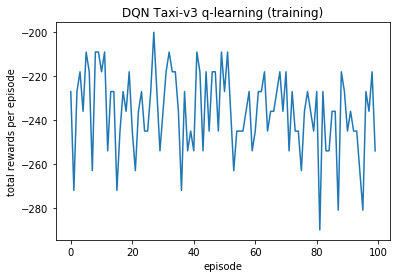

In [233]:
## Evaluation

episode = range(0, EPISODES, 1)
plt.plot(episode, ep_rewards)
plt.ylabel("total rewards per episode")
plt.xlabel("episode")
plt.title("DQN Taxi-v3 q-learning (training)")
plt.show()

In [0]:
## Debug replay buffer

# replay_buffer = Replay()
# last_observation = env.reset()

# for _ in range(10):

#   action = 0
#   observation, reward, done, info = env.step(action)
#   # last_observation, action, reward, observation
#   replay_buffer.write((last_observation, action, reward, observation))
#   last_observation = observation

# print(replay_buffer.buffer)

# batch = replay_buffer.read(3)
# print(batch)

# print([s[0] for s in batch])
# print('np.shape(batch)[0]', np.shape(batch)[0])
# batch[0][3]

In [0]:
# print(env.observation_space)
# print(env.action_space)
# observation = env.reset()
# print("observation", observation)
# print("env.step", env.step(0))
# nb_actions = env.action_space.n
# nb_states = env.observation_space
# print(nb_actions)
# print(nb_states)

In [0]:
# reply = Replay()
# action = 0
# last_observation,  = env.step(action)
# print(step)
# reply.write()
# reply.read(10)

In [0]:
## random exploration

# for ep in range(20):
#   observation = env.reset()
#   for t in range(100):
#     clear_output(wait = True)
#     env.render()
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     sleep(.5)

In [0]:
## demonstration

# # simple demonstration that network is able to train property
# with tf.Graph().as_default():
#   with tf.Session() as sess:
#     f = Network(sess, 1, 6)
#     sess.run(tf.global_variables_initializer())
    
#     # make demo input
#     x = np.random.randn(10000, 1)
#     # make demo output
#     tmp_1 = 2 * x[:,0]
#     tmp_2 = x[:,0]**2
#     tmp_3 = x[:,0]**3
#     tmp_4 = 0.1 * x[:,0]
#     tmp_5 = 0.3 * x[:,0]
#     tmp_6 = 5 * x[:,0]**2
#     y = np.transpose([tmp_1, tmp_2, tmp_3, tmp_4, tmp_5, tmp_6])

#     # check MSE before training
#     print('MSE at iteration 0 is {}'.format(((f.compute(x) - y)**2).mean()))

#     # train
#     iteration = 5000
#     for i in range(iteration):
#       f.train(x, y)

#     # check MSE after training
#     print('MSE at iteration {} is {}'.format(iteration, ((f.compute(x) - y)**2).mean()))

# # We can check that MSE decreased after training so our network is working

In [0]:
# x = np.random.randn(10000, 4)
# tmp_1 = x[:,0] + x[:,1]**2
# tmp_2 = x[:,2] + x[:,3]**3
# print(tmp_1.shape, tmp_2.shape)
# y = np.transpose([ x[:,0] + x[:,1]**2, x[:,2] + x[:,3]**3 ])
# print(x.shape, y.shape)

# x = np.random.randn(10000, 1)
# tmp_1 = 2 * x[:,0]
# tmp_2 = x[:,0]**2
# tmp_3 = x[:,0]**3
# tmp_4 = 0.1 * x[:,0]
# y = np.transpose([tmp_1, tmp_2, tmp_3, tmp_4])
# print(x.shape, y.shape)
# print(y[0:4, :])
# print(y[0,:])
# print(np.argmax(y[0, :]))

In [0]:
# model = Sequential()
# model.add(Dense(32, input_shape = (INPUT_SIZE, ), activation = 'relu'))
# model.add(Dense(OUTPUT_SIZE, activation = 'linear'))

# model.summary()